# SEPP Estimation test bed

An attempt to replicate the appendix of Mohler et al.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import open_cp.sepp as sepp
import open_cp.sources.sepp as seppsim
import open_cp
import open_cp.kernels

In [2]:
region = open_cp.RectangularRegion(-50, 50, -50, 50)
background_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.HomogeneousPoisson(rate=5.71),
    seppsim.GaussianSpaceSampler([0,0], [4.5**2, 4.5**2], 0))
total_rate = 0.2
trigger_sampler = seppsim.InhomogeneousPoissonFactors(seppsim.Exponential(exp_rate=0.1, total_rate=total_rate),
    seppsim.GaussianSpaceSampler([0,0], [0.01**2, 0.1**2], 0))
sampler = seppsim.SelfExcitingPointProcess(region, background_sampler, trigger_sampler)

## Background events

These are a constant rate marked Poisson process, with the "marks" (the space coordinates) normally distributed.  It is not clear to me why Mohler et al. chose 5.71 as the Poisson rate!

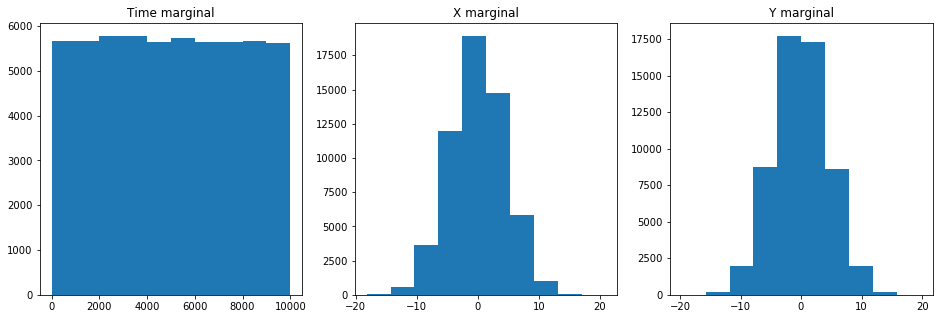

In [3]:
backs = background_sampler.sample(0, 10000)
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i, t in enumerate(["Time", "X", "Y"]):
    ax[i].hist(backs[i])
    ax[i].set_title(t + " marginal")

## Triggered events

I believe there is a **mis-print in the paper** here.  They display the formula

$$ g(t,x,y) = \theta \omega \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
with parameters $\sigma_x=0.01, \sigma_y=0.1, \theta=0.2, \omega^{-1}=10$.  However, in Figure A.2. they show the time marginal (i.e. integrate out $x$ and $y$ which is an exponential decay with value $0.02 = \theta\omega$ at $t=0$.

Thus, I believe that the normalisation of the Gaussian is missing, and we should have
$$ g(t,x,y) = \frac{\theta}{2\pi\sigma_x\sigma_y} \omega \exp(-\omega t) \exp\Big(-\frac{x^2}{2\sigma_x^2}\Big)\exp\Big(-\frac{y^2}{2\sigma_y^2}\Big) $$
The marginals for $x$ and $y$ also agree with this.

In [4]:
trigs = []
for _ in range(50000):
    x = trigger_sampler.sample(0, 100)
    for coord in x.T:
        trigs.append(coord)
trigs = np.asarray(trigs).T
trigs.shape

(3, 9965)

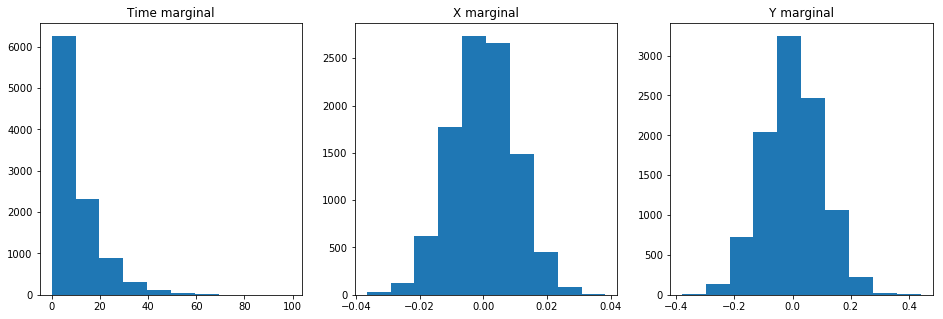

In [5]:
fig, ax = plt.subplots(ncols=3, figsize=(16,5))
for i, t in enumerate(["Time", "X", "Y"]):
    ax[i].hist(trigs[i])
    ax[i].set_title(t + " marginal")

In [6]:
pts = sampler.sample(0,500)
pts = pts[:, 2000:]
pts.shape

(3, 1418)

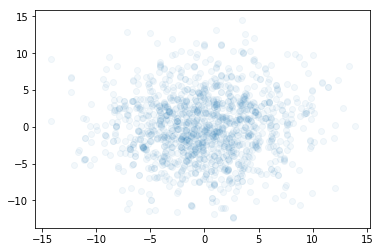

In [7]:
plt.scatter(pts[1], pts[2], alpha=0.05)

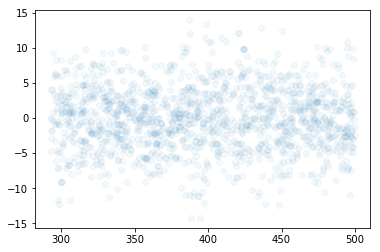

In [8]:
plt.scatter(pts[0], pts[1], alpha=0.05)

## Using the real distributions

If we use the actual kernels the data was sampled from, then we find that most events are classified as "background".

In [9]:
def actual_background_kernel(pts):
    norm = 2 * 4.5 * 4.5
    return 5.71 * np.exp(- (pts[1]**2 + pts[2]**2) / norm) / (norm * np.pi)

def actual_trigger_kernel(pts):
    sigma_x = 0.01
    sigma_y = 0.1
    theta = 0.2
    omega = 1 / 10
    return ( theta * omega * np.exp(-omega * pts[0]) *
        np.exp(-pts[1]**2 / (2 * sigma_x**2)) * np.exp(-pts[2]**2 / (2 * sigma_y**2))
        / (2 * np.pi * sigma_x * sigma_y) )

In [10]:
p = sepp.p_matrix(pts, actual_background_kernel, actual_trigger_kernel)
backs, trigs = sepp.sample_points(pts, p)
backs.shape, trigs.shape

((3, 1141), (3, 277))

## Optimising

To start the optimisation, we need to provide reasonable "bandwidths" for the data.  The `StocasticDecluster` class comes with parameters suitable for real data, so we need to override them.

In [21]:
import importlib
importlib.reload(sepp)

<module 'open_cp.sepp' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\PredictCode\\open_cp\\sepp.py'>

In [27]:
decluster = sepp.StocasticDecluster()
decluster.points = pts
decluster.background_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE()
decluster.trigger_kernel_estimator = open_cp.kernels.KthNearestNeighbourGaussianKDE()

decluster.initial_space_bandwidth = 0.05
decluster.initial_time_bandwidth = 10

In [28]:
p = sepp.initial_p_matrix(pts)
p

array([[  1.00000000e+00,   2.13602337e-05,   1.96318981e-05, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   9.99978640e-01,   5.86716118e-04, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   0.00000000e+00,   9.99393652e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          9.99973644e-01,   1.44402374e-05,   5.77590749e-06],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   9.99984961e-01,   2.53966952e-04],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   9.99740017e-01]])

In [29]:
backs, trigs = sepp.sample_points(pts, p)
backs.shape, trigs.shape

((3, 1418), (3, 0))

In [12]:
bkernel = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(backs)
tkernel = open_cp.kernels.kth_nearest_neighbour_gaussian_kde(trigs)

C:\Users\Matthew\Anaconda3\lib\site-packages\numpy\core\_methods.py:82: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)
C:\Users\Matthew\Anaconda3\lib\site-packages\numpy\core\_methods.py:114: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
C:\Users\Matthew\Anaconda3\lib\site-packages\scipy\spatial\kdtree.py:320: RuntimeWarning: invalid value encountered in maximum
  side_distances = np.maximum(0,np.maximum(x-self.maxes,self.mins-x))


TypeError: 'float' object is not subscriptable

In [10]:
p = sepp.p_matrix(pts, bkernel, tkernel)
p

array([[  1.00000000e+00,   9.58780626e-01,   1.85780173e-01, ...,
          7.20689356e-10,   8.03909866e-10,   7.55783177e-10],
       [  0.00000000e+00,   4.12193737e-02,   8.06061252e-01, ...,
          5.01005850e-10,   5.89378784e-10,   5.21069700e-10],
       [  0.00000000e+00,   0.00000000e+00,   8.15857564e-03, ...,
          5.02440973e-10,   5.90770687e-10,   5.22865858e-10],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.61136987e-04,   2.00539426e-02,   1.22705855e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.82858069e-04,   6.19044911e-03],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   1.63226975e-04]])